In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('rfm_xmas19.txt',parse_dates=['trans_date'])
df.head()

,customer_id,trans_date,tran_amount
0,FM5295,2017-11-11,35
1,FM4768,2019-12-15,39
2,FM2122,2017-11-26,52
3,FM1217,2016-08-16,99
4,FM1850,2018-08-20,78


In [3]:
df.duplicated().value_counts()

False    124993
True          7
dtype: int64

In [4]:
best_churn = pd.DataFrame(df.groupby(['customer_id'])['trans_date'].max())
best_churn.head()

,trans_date
customer_id,
FM1112,2019-10-14
FM1113,2019-11-09
FM1114,2019-11-12
FM1115,2019-12-05
FM1116,2019-05-25


In [5]:
cutoff_date = dt.datetime(2019,10,16)

best_churn['trans_date'].apply(lambda x: if 1 cutoff_date > x else 0)

In [6]:
best_churn['churned'] = best_churn['trans_date'].apply(lambda x: 1 if cutoff_date > x else 0)
best_churn.head()

,trans_date,churned
customer_id,,
FM1112,2019-10-14,1
FM1113,2019-11-09,0
FM1114,2019-11-12,0
FM1115,2019-12-05,0
FM1116,2019-05-25,1


In [7]:
best_churn['transactions'] = df.groupby('customer_id')['customer_id'].count()

In [8]:
best_churn['amount_spent'] = df.groupby('customer_id')['tran_amount'].sum()

In [9]:
best_churn.sample(3)

,trans_date,churned,transactions,amount_spent
customer_id,,,,
FM3995,2019-11-14,0,15,1044
FM5699,2019-10-23,0,17,1240
FM4527,2019-08-21,1,18,1329


In [10]:
best_churn.drop(['trans_date'],axis=1,inplace=True)

In [11]:
best_churn[['transactions','amount_spent']].describe().loc[['min','max']]

,transactions,amount_spent
min,4.0,149.0
max,39.0,2933.0


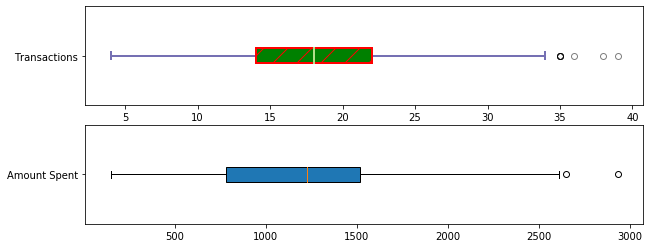

In [12]:

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,4))

bx1 = ax1.boxplot(best_churn['transactions'],vert=False,patch_artist=True)
ax1.set_yticklabels(['Transactions'])


bx2 = ax2.boxplot(best_churn['amount_spent'],vert=False,patch_artist=True)
ax2.set_yticklabels(['Amount Spent'])

# just me customizing boxplot , swear wont do this tedious code

aesbox = ['boxes','whiskers','caps','medians','fliers']

for item in aesbox:
    if item == 'boxes':
        for box in bx1['boxes']:
            box.set(color='red', linewidth=2)
            box.set(facecolor = 'green' )
            box.set(hatch = '/')
    ## change color and linewidth of the whiskers
    elif item == 'whiskers':
        for whisker in bx1['whiskers']:
            whisker.set(color='#7570b3', linewidth=2)
    elif item == 'caps':
    ## change color and linewidth of the caps
        for cap in bx1['caps']:
            cap.set(color='#7570b3', linewidth=2)
    ## change color and linewidth of the medians
    elif item == 'medians':
        for median in bx1['medians']:
            median.set(color='#b2df8a', linewidth=2)
    elif item == 'fliers':
    ## change the style of fliers and their fill
        for flier in bx1['fliers']:
            flier.set(marker='o', color='#e7298a', alpha=0.5)

In [13]:
best_churn['scale_transactions'] = best_churn['transactions'].apply(lambda x: (x - best_churn['transactions'].min())/(best_churn['transactions'].max() - best_churn['transactions'].min()) )

In [14]:
best_churn['scale_spent'] = best_churn['amount_spent'].apply(lambda x: (x - best_churn['amount_spent'].min())/(best_churn['amount_spent'].max() - best_churn['amount_spent'].min()))

In [15]:
best_churn.sample(2)

,churned,transactions,amount_spent,scale_transactions,scale_spent
customer_id,,,,,
FM3243,1,18,1358,0.400000,0.434267
FM2957,1,19,1251,0.428571,0.395833


In [16]:
best_churn['score'] = best_churn[['scale_transactions','scale_spent']].apply(lambda x: 0.5 * x['scale_transactions'] + 0.5 * x['scale_spent'],axis=1)

In [17]:
best_churn.sample(3)

,churned,transactions,amount_spent,scale_transactions,scale_spent,score
customer_id,,,,,,
FM1999,0,14,1002,0.285714,0.306394,0.296054
FM3548,0,19,1398,0.428571,0.448635,0.438603
FM2965,1,13,793,0.257143,0.231322,0.244232


In [23]:
best_churn.sort_values('score',ascending=False,inplace=True)

In [24]:
best_churn.sample(4)

,churned,transactions,amount_spent,scale_transactions,scale_spent,score
customer_id,,,,,,
FM3810,1,14,1027,0.285714,0.315374,0.300544
FM7343,1,14,713,0.285714,0.202586,0.244150
FM1298,0,21,1561,0.485714,0.507184,0.496449
FM4115,1,24,1763,0.571429,0.579741,0.575585


employ the following strategy to determine the cutoff point:

Find the mean of the transactions and compute 30% of that. Make this the value of the coupon;
Divide the budget by the value obtained above to get the number of coupons you're going to be sending out;
Pick the first  churned customers where  is the result of the calculation done in the previous step. This is your cutoff point.

avoid price dumping

In [36]:
coupon = best_churn['amount_spent'].mean() * 0.3

The budget is $1,000.
No indication was given about how much each coupon would be worth — it's for you to decide.
The coupons need to be good enough to prompt people to actually use them.
They can't be too high because:
That reduces the number of customers who get them.
It would be like giving away money.
Due to price dumping, it could be illegal.

In [37]:
nr_of_customers = int(1000/coupon)

In [44]:
top_50_churned = best_churn[best_churn['churned']==1][:50]

In [45]:
top_50_churned.to_csv('best_customers.txt')

In [ ]:

coupon = data['tran_amount'].mean() * 0.3
nr_of_customers = 1000/coupon
print(coupon, nr_of_customers, sep="\n")

In [ ]:
# plt.subplot(1,2,1)
# plt.boxplot(best_churn['transactions'])

# plt.subplot(1,2,2)
# plt.boxplot(best_churn['amount_spent'])